In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline
sns.set()
pd.options.mode.chained_assignment = None


cl = pd.read_csv('NCDB_1999_to_2017.csv',  na_values=['UU', 'XX', 'U', 'X', 'UUUU'])
cl.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,1999,1.0,1.0,20.0,2,2.0,34,NaN,1,5,...,06,1990,01,M,41,11,1,NaN,1.0,752
1,1999,1.0,1.0,20.0,2,2.0,34,NaN,1,5,...,01,1987,01,M,19,11,1,NaN,1.0,752
2,1999,1.0,1.0,20.0,2,2.0,34,NaN,1,5,...,01,1987,02,F,20,13,2,02,2.0,752
3,1999,1.0,1.0,8.0,2,1.0,01,NaN,5,3,...,01,1986,01,M,46,11,1,NaN,1.0,753
4,1999,1.0,1.0,8.0,2,1.0,01,NaN,5,3,...,NN,NNNN,01,M,05,99,2,NaN,3.0,753


In [2]:
cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6772563 entries, 0 to 6772562
Data columns (total 23 columns):
 #   Column  Dtype  
---  ------  -----  
 0   C_YEAR  int64  
 1   C_MNTH  float64
 2   C_WDAY  float64
 3   C_HOUR  float64
 4   C_SEV   int64  
 5   C_VEHS  float64
 6   C_CONF  object 
 7   C_RCFG  object 
 8   C_WTHR  object 
 9   C_RSUR  object 
 10  C_RALN  object 
 11  C_TRAF  object 
 12  V_ID    float64
 13  V_TYPE  object 
 14  V_YEAR  object 
 15  P_ID    object 
 16  P_SEX   object 
 17  P_AGE   object 
 18  P_PSN   object 
 19  P_ISEV  object 
 20  P_SAFE  object 
 21  P_USER  float64
 22  C_CASE  int64  
dtypes: float64(6), int64(3), object(14)
memory usage: 1.2+ GB


In [3]:
cl.V_ID.unique()

array([ 1.,  2., 99.,  3.,  4., nan,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
       38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
       51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.,
       64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 83., 85.,
       86., 75., 76., 77.])

## Driver and not a parked car

In [4]:
print(cl.C_CASE.count())
print(cl.C_CASE.nunique())
print(cl[(cl.P_PSN == '11') & (cl.C_CONF != '41')].isnull().sum())



6772563
2570235
C_YEAR         0
C_MNTH       229
C_WDAY       920
C_HOUR     44230
C_SEV          0
C_VEHS       356
C_CONF    150214
C_RCFG    365129
C_WTHR     63897
C_RSUR     57214
C_RALN    305771
C_TRAF    177401
V_ID          80
V_TYPE     29849
V_YEAR    289818
P_ID          12
P_SEX     162289
P_AGE     199223
P_PSN          0
P_ISEV     30895
P_SAFE    494163
P_USER     73002
C_CASE         0
dtype: int64


In [5]:
print(cl[(cl.P_PSN == '11') & (cl.C_WDAY.isnull() == False)
        & (cl.C_HOUR.isnull() == False) & (cl.C_VEHS.isnull() == False)
        & (cl.C_CONF.isnull() == False) & (cl.C_CONF != 'QQ')
        & (cl.C_RCFG.isnull() == False) & (cl.C_RCFG != 'QQ')
        & (cl.C_WTHR.isnull() == False) & (cl.C_WTHR != 'Q')
        & (cl.C_RSUR.isnull() == False) & (cl.C_RSUR != 'Q')
        & (cl.V_TYPE.isnull() == False) & (cl.V_TYPE != 'QQ') & (cl.V_TYPE != 'NN')
        & (cl.P_SEX.isnull() == False) & (cl.P_SEX!='N')
        & (cl.P_AGE.isnull() == False) & (cl.P_AGE!='NN')
        ].groupby('C_YEAR').C_CASE.agg('count'))

C_YEAR
1999    204014
2000    207504
2001    200613
2002    205959
2003    202081
2004    194809
2005    194022
2006    186969
2007    183407
2008    168417
2009    164705
2010    162130
2011    155379
2012    162355
2013    161195
2014    152356
2015    161623
2016    159699
2017    154607
Name: C_CASE, dtype: int64


# Dealing with nulls

## Just replace month with random and changed the type to int
## remove rows with null or unknown values for a subset of columns
### We look at C_RALN,  C_TARF and V_YEAR separately. The other columns will be ignored.

In [6]:
print(cl.C_MNTH.isnull().sum())
print(cl.C_WDAY.isnull().sum())
print(cl.C_HOUR.isnull().sum())
print(cl.shape[0])

cl.C_MNTH = cl.C_MNTH.fillna(pd.Series(np.random.randint(1, 12, cl.C_MNTH.shape)))
cl.C_MNTH = cl.C_MNTH.astype(np.int64)

clsb1 = cl[(cl.P_PSN == '11') & (cl.C_WDAY.isnull() == False)
        & (cl.C_HOUR.isnull() == False) & (cl.C_VEHS.isnull() == False)
        & (cl.C_CONF.isnull() == False) & (cl.C_CONF != 'QQ')
        & (cl.C_RCFG.isnull() == False) & (cl.C_RCFG != 'QQ')
        & (cl.C_WTHR.isnull() == False) & (cl.C_WTHR != 'Q')
        & (cl.C_RSUR.isnull() == False) & (cl.C_RSUR != 'Q')
        & (cl.V_TYPE.isnull() == False) & (cl.V_TYPE != 'QQ') & (cl.V_TYPE != 'NN')
        & (cl.P_SEX.isnull() == False) & (cl.P_SEX!='N')
        & (cl.P_AGE.isnull() == False) & (cl.P_AGE!='NN')]

clsb1.isnull().sum()

425
1364
66337
6772563


C_YEAR         0
C_MNTH         0
C_WDAY         0
C_HOUR         0
C_SEV          0
C_VEHS         0
C_CONF         0
C_RCFG         0
C_WTHR         0
C_RSUR         0
C_RALN     30295
C_TRAF     68402
V_ID           0
V_TYPE         0
V_YEAR    101670
P_ID           8
P_SEX          0
P_AGE          0
P_PSN          0
P_ISEV     14380
P_SAFE    273428
P_USER     11198
C_CASE         0
dtype: int64

## Number of accidents per year

### Plot 01

# Accidents are declined over the years 
## Our sample data kept a fair proportion of data for each year 

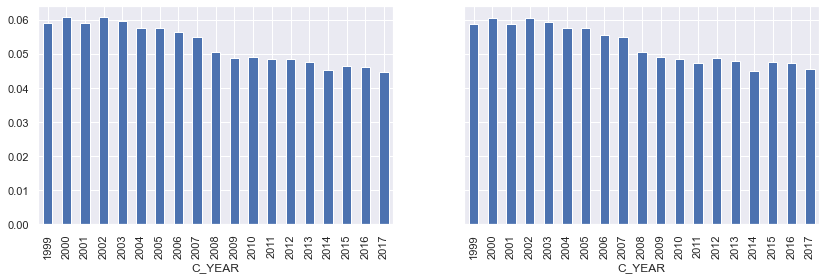

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 4))  
df = cl.groupby('C_YEAR').C_CASE.nunique()/cl.C_CASE.nunique()
df.plot(kind='bar', ax=ax1)
df = clsb1.groupby('C_YEAR').C_CASE.nunique()/clsb1.C_CASE.nunique()
df.plot(kind='bar', ax=ax2)

## Age: Create Age Boxes

In [8]:
clsb1.P_AGE = clsb1.P_AGE.astype(np.int64)

# create age boxes

bin = [1, 16, 36, 55, 76, 99]
bin_labels = ['<16', '16-36', '36-56', '56-76', '>76']
clsb1['AgeBox'] = pd.cut(clsb1['P_AGE'], bin, right = False, labels = bin_labels);
clsb1[['P_AGE', 'AgeBox']]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-8-d14538ad063d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clsb1['AgeBox'] = pd.cut(clsb1['P_AGE'], bin, right = False, labels = bin_labels);


,P_AGE,AgeBox
52,33,16-36
54,70,56-76
125,38,36-56
139,55,56-76
141,34,16-36
...,...,...
6772527,27,16-36
6772529,23,16-36
6772533,17,16-36
6772534,19,16-36


### Plot 2

# Comparing drivers by age and gender

[Text(0, 0, '<16'),
 Text(0, 0, '16-36'),
 Text(0, 0, '36-56'),
 Text(0, 0, '56-76'),
 Text(0, 0, '>76')]

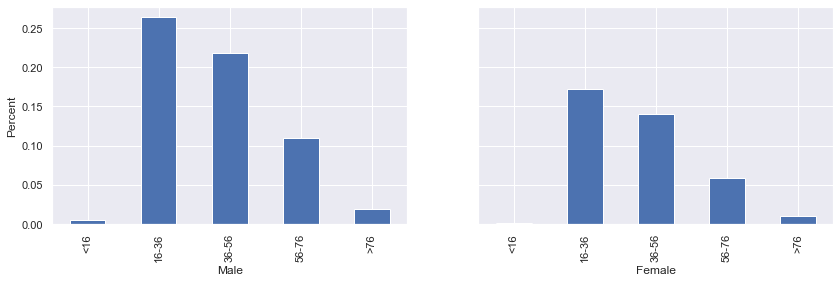

In [9]:
#ax = sns.barplot(x="x", y="x", data=cl_age, estimator=lambda AgeBox: len(AgeBox) / len(cl_age) * 100)
#ax.set(ylabel="Percent")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 4))  
plt.xlabel = 'Male'

df = clsb1[(clsb1.P_SEX=='M')].groupby(['AgeBox']).agg({'C_CASE': 'count'})/clsb1.agg({'C_CASE': 'count'})
df.unstack().plot(kind='bar', ax = ax1 )
ax1.set(ylabel="Percent", xlabel="Male")
ax1.set_xticklabels(bin_labels)

df = clsb1[(clsb1.P_SEX=='F')].groupby(['AgeBox']).agg({'C_CASE': 'count'})/clsb1.agg({'C_CASE': 'count'})
df.unstack().plot(kind='bar', ax = ax2)
ax2.set(xlabel="Female")
ax2.set_xticklabels(bin_labels)



### Plot 3

# There is an outliner in V_Type, in this study we just focus on V_Type = 01
## Light Duty Vehicle 

[Text(0.5, 0, 'Vehicle Type')]

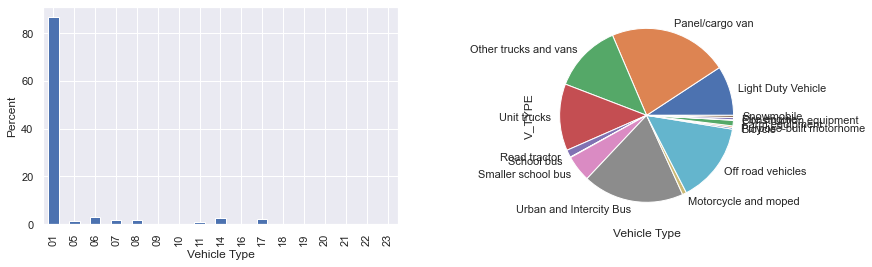

In [250]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 4))  
plt.grid(b=True, which='major', color='#666666', linestyle='-')

clsb1.V_TYPE.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='bar', ax = ax1)
ax1.set(ylabel="Percent", xlabel="Vehicle Type")
clsb1[clsb1.V_TYPE!='01'].V_TYPE.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='pie', 
                                                                                                  labels = ['Light Duty Vehicle' ,'Panel/cargo van' ,'Other trucks and vans' ,'Unit trucks' ,'Road tractor' ,'School bus' ,'Smaller school bus' ,'Urban and Intercity Bus' ,'Motorcycle and moped' ,'Off road vehicles' ,'Bicycle' ,'Purpose-built motorhome' ,'Farm equipment' ,'Construction equipment' ,'Fire engine' ,'Snowmobile' ,'Street car' ,'NA'],
                                                                                                  ax = ax2)
ax2.set(xlabel="Vehicle Type")

### Plot 4

# most of the collisions are in C_RCFG = 02
# Roadway configuration: At an intersection of at least two public roadways

[Text(0, 0.5, 'Percent'), Text(0.5, 0, 'Roadway configuration')]

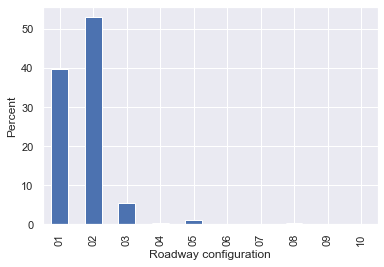

In [15]:

ax = clsb1.C_RCFG.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='bar')
ax.set(ylabel="Percent", xlabel="Roadway configuration")

### Plot 5

# Most of the collisions are in C_CONF = 21 rear-end collision

[Text(0, 0.5, 'Percent'), Text(0.5, 0, 'Collision configuration')]

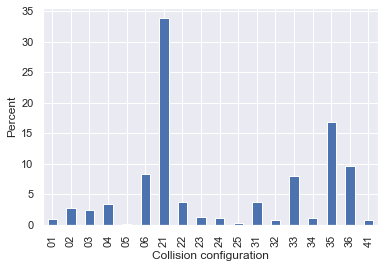

In [16]:

ax = clsb1.C_CONF.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='bar')
ax.set(ylabel="Percent", xlabel="Collision configuration")

### Plot 6

## Most of the accident happend during June-Oct ! Good weather?!
## Between 15:00 - 17:00

[Text(0.5, 0, 'Vehicle Type')]

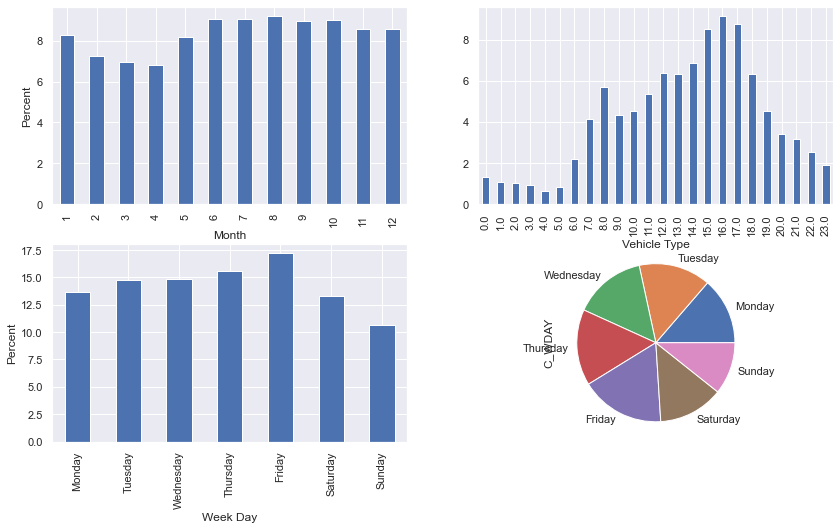

In [252]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(14, 8))  
plt.grid(b=True, which='major', color='#666666', linestyle='-')

clsb1.C_MNTH.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='bar', ax=ax1)
ax1.set(ylabel="Percent", xlabel="Month")
clsb1.C_HOUR.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='bar', ax=ax2)
ax2.set(xlabel="Hours")
clsb1.C_WDAY.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='bar', ax=ax3)
ax3.set(ylabel="Percent", xlabel="Week Day")
ax3.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
clsb1.C_WDAY.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='pie', 
                                                                              labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                                                                               ax = ax4)
ax2.set(xlabel="Vehicle Type")


### Plot 7

## Weather clear and sunny
## Road surface Dry and Normal

[Text(0, 0, 'Dry, normal'),
 Text(0, 0, 'Wet'),
 Text(0, 0, 'Snow (fresh, loose snow)'),
 Text(0, 0, 'Slush ,wet snow'),
 Text(0, 0, 'Icy'),
 Text(0, 0, 'Sand/gravel/dirt'),
 Text(0, 0, 'Muddy'),
 Text(0, 0, 'Oil'),
 Text(0, 0, 'Flooded')]

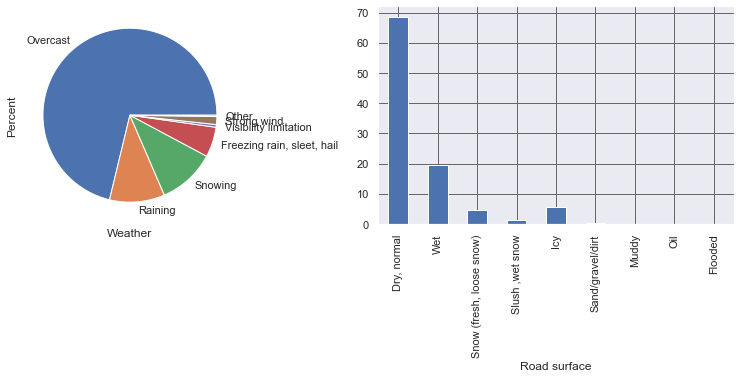

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 4))  
plt.grid(b=True, which='major', color='#666666', linestyle='-')

clsb1.C_WTHR.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='pie', ax=ax1, labels = ['Overcast','Raining','Snowing','Freezing rain, sleet, hail', 'Visibility limitation','Strong wind','Other'])
ax1.set(ylabel="Percent", xlabel="Weather")

clsb1.C_RSUR.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='bar', ax=ax2)
ax2.set(xlabel="Road surface")
ax2.set_xticklabels(['Dry, normal', 'Wet','Snow (fresh, loose snow)','Slush ,wet snow', 'Icy','Sand/gravel/dirt','Muddy','Oil','Flooded','Other'])

In [ ]:
Plot 8

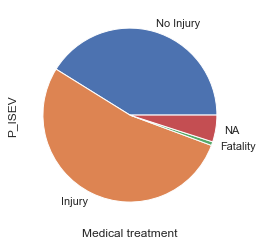

In [34]:
ax = cl.P_ISEV.value_counts(normalize=True).mul(100).round(2).sort_index().plot(kind='pie', labels = ['No Injury', 'Injury','Fatality','NA'])
ax.set(xlabel="Medical treatment")



# Correlations

### Plot 10

## Weather and Surface

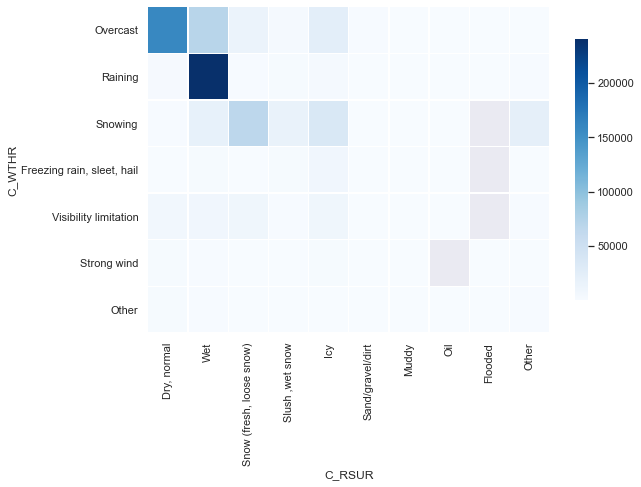

In [69]:
df = cl[cl.C_WTHR!='1'].groupby(['C_WTHR', 'C_RSUR']).C_CASE.nunique().unstack()

fig, ax = plt.subplots(figsize=(9, 6))
# plot heatmap
sns.heatmap(df, cmap="Blues",
           linewidth=0.3, cbar_kws={"shrink": .8})

xticks_labels = ['Dry, normal', 'Wet','Snow (fresh, loose snow)','Slush ,wet snow', 'Icy','Sand/gravel/dirt','Muddy','Oil','Flooded','Other']
yticks_labels = ['Overcast','Raining','Snowing','Freezing rain, sleet, hail', 'Visibility limitation','Strong wind','Other']

plt.xticks(np.arange(10) + .5, labels=xticks_labels, rotation='vertical' )
plt.yticks(np.arange(7) + .5, labels=yticks_labels, rotation='horizontal')
plt.show()


### Plot 11

## Weather and Number of Vehicles

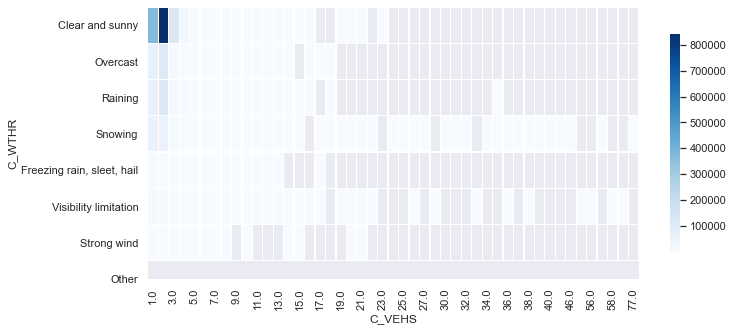

In [308]:
df = clsb1.groupby(['C_WTHR', 'C_VEHS']).C_CASE.nunique().unstack()

fig, ax = plt.subplots(figsize=(11, 5))
# plot heatmap
sns.heatmap(df, cmap="Blues",
           linewidth=0.3, cbar_kws={"shrink": .8})

yticks_labels = ['Clear and sunny','Overcast','Raining','Snowing','Freezing rain, sleet, hail', 'Visibility limitation','Strong wind','Other']


plt.yticks(np.arange(8) + .5, labels=yticks_labels, rotation='horizontal')
plt.show()


### Plot 12

## Month and Hours
## Month and Week days
## Week days and Hours
## Week days and Severity

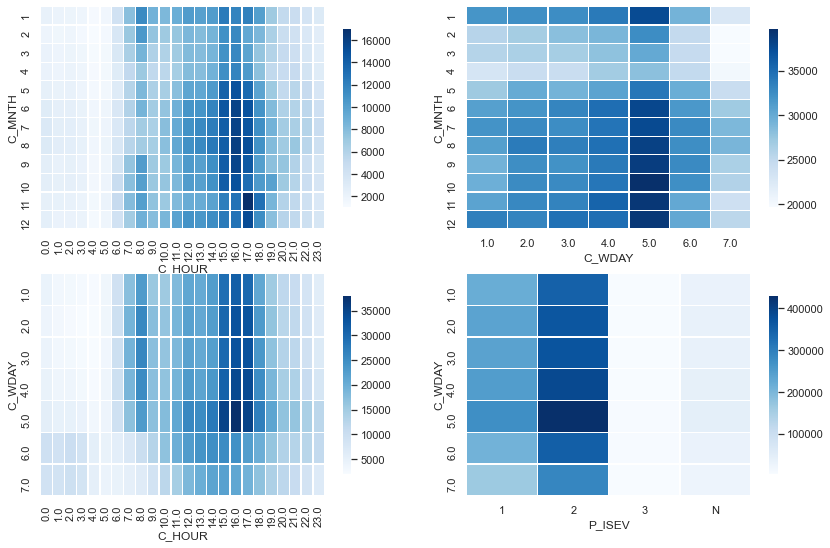

In [263]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(14, 9))  
plt.grid(b=True, which='major', color='#666666', linestyle='-')


df = clsb1.groupby(['C_MNTH', 'C_HOUR']).C_CASE.nunique().unstack()
sns.heatmap(df, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8}, ax = ax1)

df = cl.groupby(['C_MNTH', 'C_WDAY']).C_CASE.nunique().unstack()
sns.heatmap(df, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8}, ax = ax2)

df = cl.groupby(['C_WDAY', 'C_HOUR']).C_CASE.nunique().unstack()
sns.heatmap(df, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8}, ax = ax3)

df = cl.groupby(['C_WDAY', 'P_ISEV']).C_CASE.nunique().unstack()
sns.heatmap(df, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8}, ax = ax4)

plt.show()

## Time series

### Plot 20

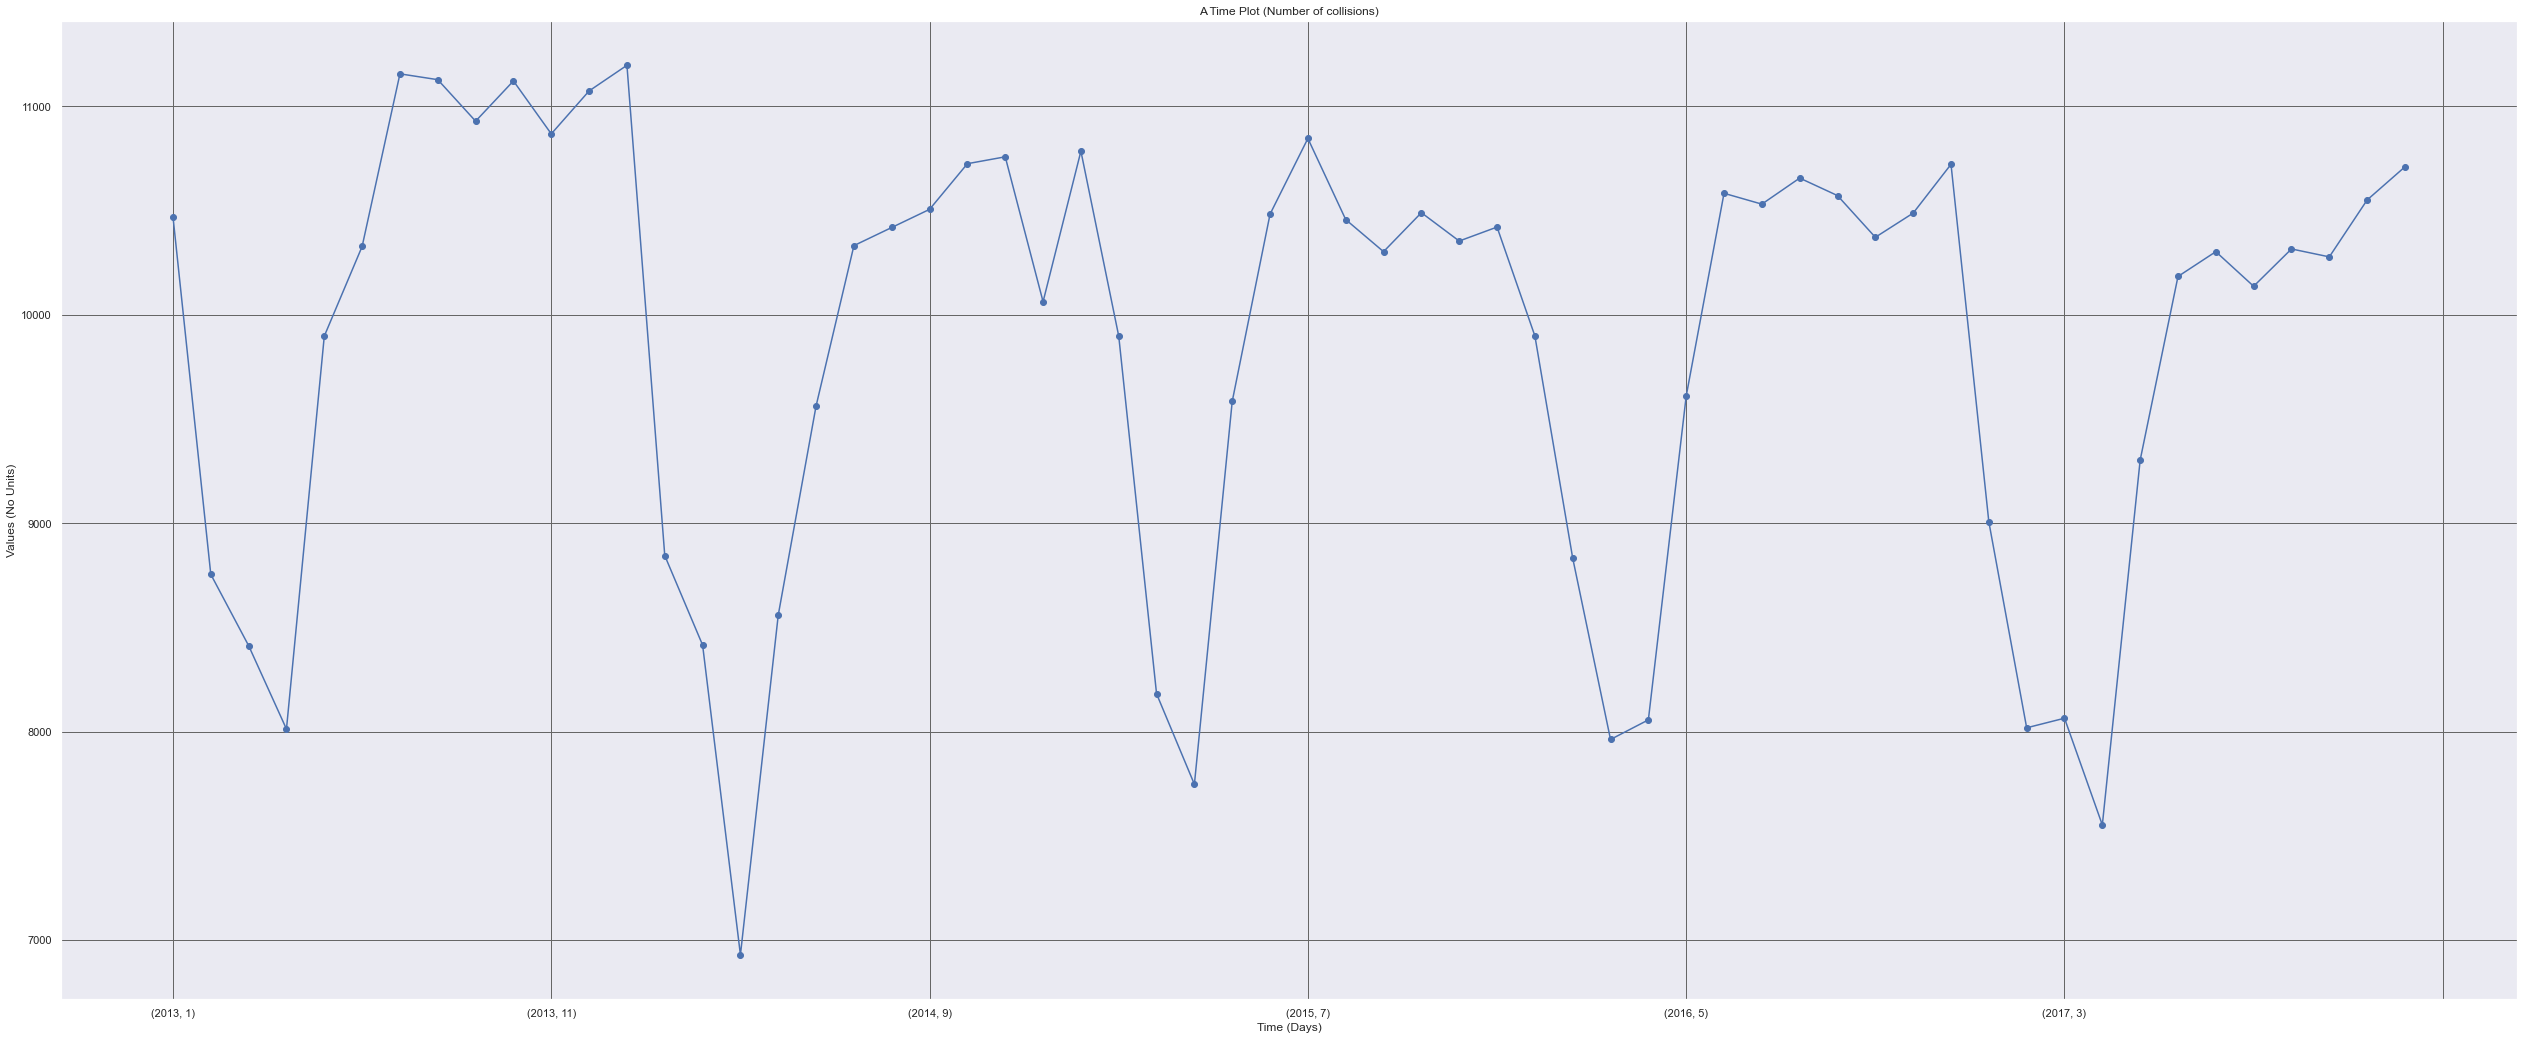

In [19]:
f, ax1 = plt.subplots(1, 1,figsize=(44, 18))  
plt.grid(b=True, which='major', color='#666666', linestyle='-')

clt = cl[(cl.C_YEAR >= 2013) &  (cl.C_YEAR < 2018)].groupby(['C_YEAR', 'C_MNTH']).C_CASE.nunique()

aTimePlot = clt.plot(style="-o", title="A Time Plot (Number of collisions)", ax = ax1)
aTimePlot.set_ylabel("Values (No Units)")
aTimePlot.set_xlabel("Time (Days)")
tmp = aTimePlot.plot()


### Plot 21

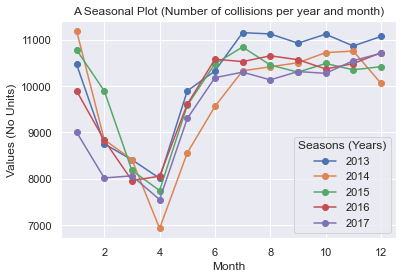

In [20]:
cltf = clt.to_frame(name="value").reset_index() 
aSeasonalFrame = cltf.pivot_table(values="value",
                       aggfunc='sum',
                       index=cltf.C_MNTH, # index for units (could be aggregates)
                       columns=cltf.C_YEAR # index for creating seasons
                      )
aSeasonalFrame.columns.name = 'Seasons (Years)'
aSeasonalPlot = aSeasonalFrame.plot(style="-o",
                                    title="A Seasonal Plot (Number of collisions per year and month)")
aSeasonalPlot.set_ylabel("Values (No Units)")
aSeasonalPlot.set_xlabel("Month")
tmp = aSeasonalPlot.plot()

### Plot 22

to learn more check https://towardsdatascience.com/time-series-forecasting-for-road-accidents-in-uk-f940e5970988

                     C_CASE
dtindex                    
1999-01-01 00:00:00      10
1999-01-01 01:00:00       9
1999-01-01 02:00:00       8
1999-01-01 03:00:00       5
1999-01-01 04:00:00       6
dtindex
1999-01-01    52.750000
1999-02-01    43.029762
1999-03-01    48.416667
1999-04-01    47.732143
1999-05-01    59.315476
Freq: MS, Name: C_CASE, dtype: float64


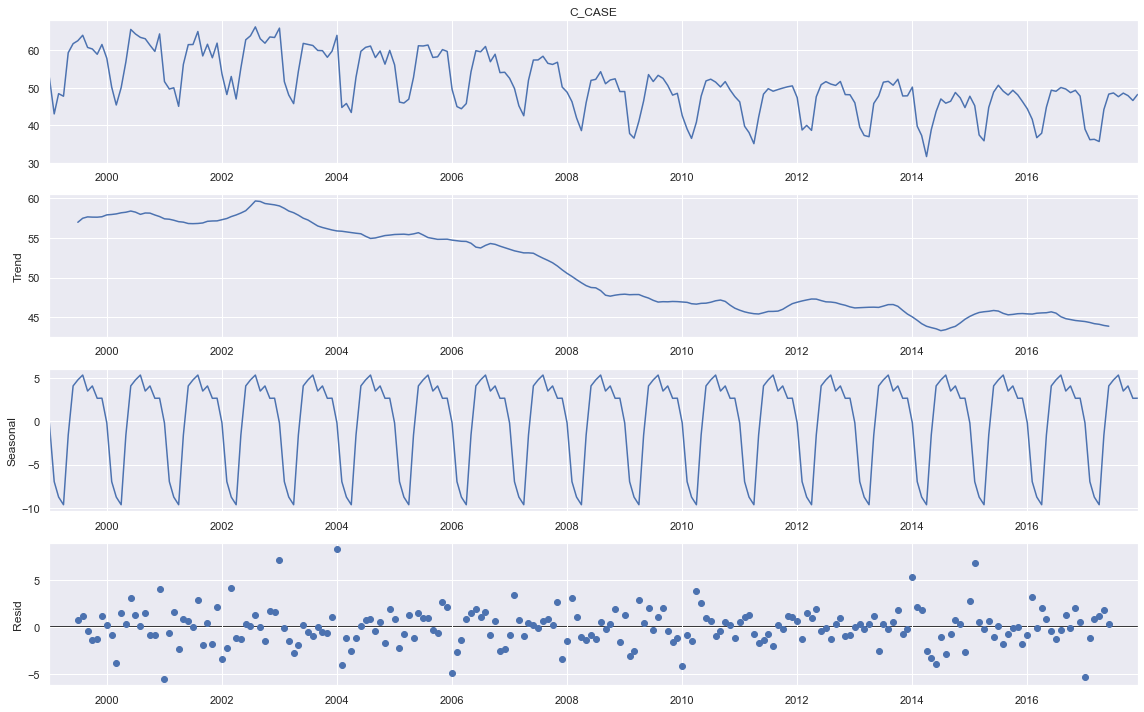

In [311]:
from pylab import rcParams
import statsmodels.api as sm

ct = clsb1.groupby(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR']).C_CASE.nunique().round(0).to_frame()
ct = ct.reset_index()

# Let's use WDat as day of the month
ct.C_WDAY = ct.C_WDAY.astype(np.int64)
ct=ct.rename(columns={"C_YEAR": "year", "C_MNTH": "month", "C_WDAY": "day", "C_HOUR": "hour"})

ct['dtindex'] = pd.to_datetime(ct[['year', 'month', 'day', 'hour']])

ct=ct.set_index('dtindex')

ct.drop(['year', 'month', 'day', 'hour'],axis=1,inplace=True)
print(ct.head())

y = ct['C_CASE'].resample('MS').mean()
print(y.head())

rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Forcast

In [265]:
# create C_COUNT column to categorize number of accidents

clsb2 = clsb1.groupby(['C_MNTH', 'C_HOUR', 'C_WTHR']).C_CASE.nunique().round(0).to_frame()
clsb2 = clsb2.reset_index()

bin = [1, 2, 5, 10, 20, 300, 100000]
bin_labels = ['1-2', '2-5', '5-10', '10-20','20-300', '>300']
clsb2['C_COUNT'] = pd.cut(clsb2['C_CASE'], bin, right = False, labels = bin_labels);

clsb2['C_COUNT'].value_counts()  # It is not very balanced but we continue
clsb2.head()

,C_MNTH,C_HOUR,C_WTHR,C_CASE,C_COUNT
0,1,0.0,1,1138,>300
1,1,0.0,2,364,>300
2,1,0.0,3,179,20-300
3,1,0.0,4,467,>300
4,1,0.0,5,54,20-300


In [302]:
#KNN

train, test = train_test_split(clsb2, test_size = 0.40, stratify = clsb2['C_COUNT'], random_state = 42)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
#, 'C_MNTH', 'C_HOUR', 'C_WTHR',
Xt = train[['C_MNTH', 'C_HOUR', 'C_WTHR']]
yt = train['C_COUNT']
scaler = MinMaxScaler() 
scaler.fit(Xt)
Xt_scaled = scaler.transform(Xt)
Xtest = test[['C_MNTH', 'C_HOUR', 'C_WTHR']]
Xtest_scaled = scaler.transform(Xtest)
n = KNeighborsClassifier(n_neighbors=5)
n.fit(Xt_scaled, yt)


KNeighborsClassifier()

In [303]:
test['predict'] = n.predict(Xtest_scaled)
print(accuracy_score(test['C_COUNT'] , test['predict'], normalize=True))

0.806615776081425


In [304]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf_clf.fit(Xt, yt) #train the model on the training set


RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [305]:
y_pred = rf_clf.predict(Xtest) #make predictions for the test set
print(y_pred.shape)
y_pred #these are the predictions made by the model
(y_pred == test['C_COUNT']).sum()/y_pred.shape[0]

(786,)


0.8206106870229007